In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocess import *
import pickle

# Data Analysis

In [5]:
# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=["SubjectID", "Session", "Mean", "Median", "STD", "fastest_10_percent", 
                           "slowest_10_percent", "SEM", "Min", "Max", "quartile_25per", "quartile_75per"])

def analyze_data(subjectID_path, output_folder, subjectID):
    global results_df 
    
    # Iterate through sessions '1', '2', '3', and '4'
    for session in os.listdir(subjectID_path):
        session_path = os.path.join(subjectID_path, session)
        if os.path.isdir(session_path):
            
            # Iterate through 'aPVT' and 'visPVT' testtype
            testtypes = [f for f in os.listdir(session_path) if os.path.isdir(os.path.join(session_path, f))]

            # Initialize a list to store the results for this session
            sessions_results = []

            for testtype in testtypes:
                for csv_file in os.listdir(os.path.join(session_path, testtype)):
                    if csv_file.endswith(".csv"):
                        csv_file_path = os.path.join(session_path, testtype, csv_file)
                        # Load the CSV file into a DataFrame
                        data = pd.read_csv(csv_file_path)
                        
                        # Calling the preprocess function to process the imported data
                        data = preprocessData(filename=csv_file_path, maxThreshold_ms=500, minThreshold_ms=50)
                        #print(data)
                        # Create a Pandas Excel writer using ExcelWriter.
                        csv_path = 'metadata.csv'
                        data.to_csv(csv_path, index=False)
                        # Extracting the response time where hits are equal to 1
                        RTs = data.loc[data['Hits'] == 1, 'Response Times']

                        # Calculate the mean and median
                        mean = RTs.mean()
                        median = RTs.median()
                        STD = RTs.std()
                        SEM = RTs.sem()
                        Min = RTs.min()
                        Max = RTs.max()
                        quartile_25per = RTs.quantile(0.25)
                        quartile_75per = RTs.quantile(0.75)
                        #timestamp = data["Timestamps"]

                        # Calculate effective size (eff_size) using a fixed value of 4
                        eff_size = (mean - 4) / STD
                        eff_size_median = (median - 4) / STD

                        # Sort reaction times in ascending order
                        sorted_reaction_times = sorted(RTs)

                        # Calculate the number of elements to take from the sorted list (10% of total elements)
                        n = round(len(sorted_reaction_times) * 0.1)

                        # Get the fastest 10% of reaction times
                        fastest_10_percent = sorted_reaction_times[:n]

                        # Sort the reaction times in ascending order
                        sorted_reaction_times = sorted(RTs)
                        # Calculate the number of elements corresponding to the slowest 10%
                        n = int(0.1 * len(sorted_reaction_times))
                        # Get the slowest 10% of reaction times using negative indexing
                        slowest_10_percent = sorted_reaction_times[-n:]

                        # Append subject ID and session to the results
                        sessions_results.append((subjectID, session, mean, median, STD, fastest_10_percent, 
                                                  slowest_10_percent, SEM, Min, Max, quartile_25per, quartile_75per))

            # Create a DataFrame for the results of this sessions
            sessions_df = pd.DataFrame(sessions_results, columns=["SubjectID", "Session", "Mean", "Median", "STD", "fastest_10_percent", "slowest_10_percent", 
                                        "SEM", "Min", "Max", "quartile_25per", "quartile_75per"])

            # Concatenate the session results to the main results DataFrame
            results_df = pd.concat([results_df, sessions_df], ignore_index=True)

    # Save the main results DataFrame
    main_output_folder = os.path.join(output_folder, subjectID)
    if not os.path.exists(main_output_folder):
        os.makedirs(main_output_folder)
    main_output_file = os.path.join(main_output_folder, "main_results.csv")
    results_df.to_csv(main_output_file, index=False)

data_folder = "raw_data"
output_folder = "processed_data"

subjectIDs = ['115', '116', '117', '118', '119', '120', '121', '123', '124', '125']

for subjectID in subjectIDs:
    subjectID_path = os.path.join(data_folder, subjectID)
    analyze_data(subjectID_path, output_folder, subjectID)

# Group the means by session and create a bar plot
session_means = results_df.groupby('Session')['Mean'].mean()

In [6]:
# Calculate the means by 'SubjectID'
mean_by_subject = results_df.groupby('SubjectID')['Mean'].mean().reset_index()

# Create a Pandas Excel writer using ExcelWriter.
with pd.ExcelWriter('metadata_results_with_means.xlsx') as writer:
    results_df.to_excel(writer, sheet_name='Original_Data', index=False)
    mean_by_subject.to_excel(writer, sheet_name='Mean_by_Subject', index=False)

# Data Visualization

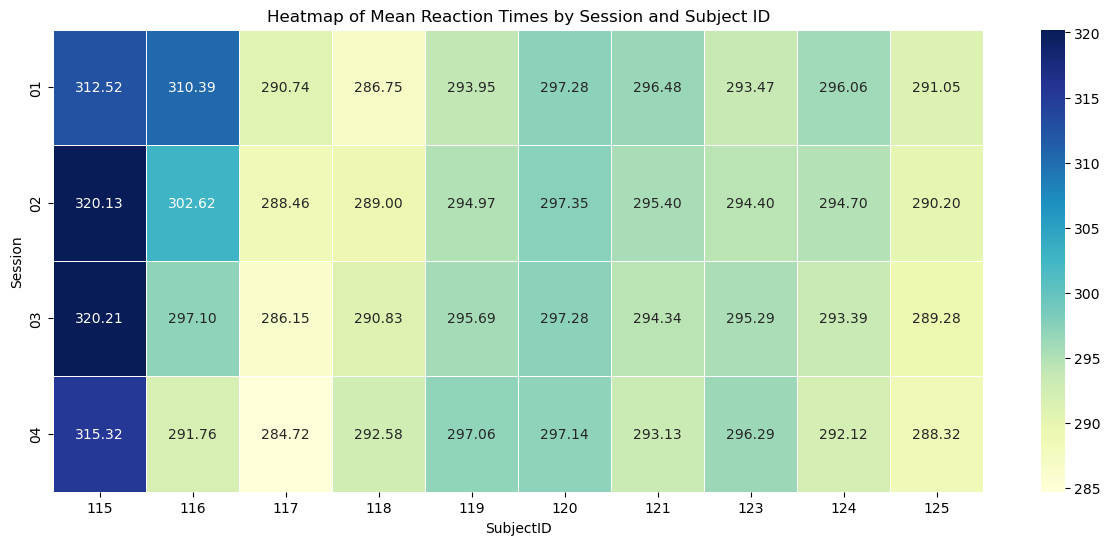

In [7]:
# Aggregate mean reaction times by 'Session' if there are duplicates
pivot_results_df = results_df.pivot_table(index='Session', columns='SubjectID', values='Mean', aggfunc='mean')

# Create the heatmap using Seaborn
plt.figure(figsize=(15, 6)) 
sns.heatmap(data=pivot_results_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)

plt.title('Heatmap of Mean Reaction Times by Session and Subject ID')
plt.show()


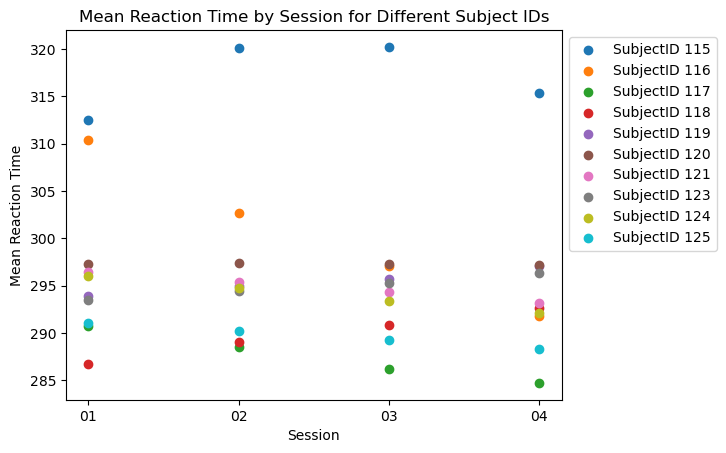

In [8]:
subjectIDs = results_df['SubjectID'].unique()

# Create a scatter plot for each subject ID
for subjectID in subjectIDs:
    subject_data = results_df[results_df['SubjectID'] == subjectID]
    session_means = subject_data.groupby('Session')['Mean'].mean()
    plt.scatter(session_means.index, session_means, label=f'SubjectID {subjectID}')

plt.xlabel('Session')
plt.ylabel('Mean Reaction Time')
plt.title('Mean Reaction Time by Session for Different Subject IDs')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


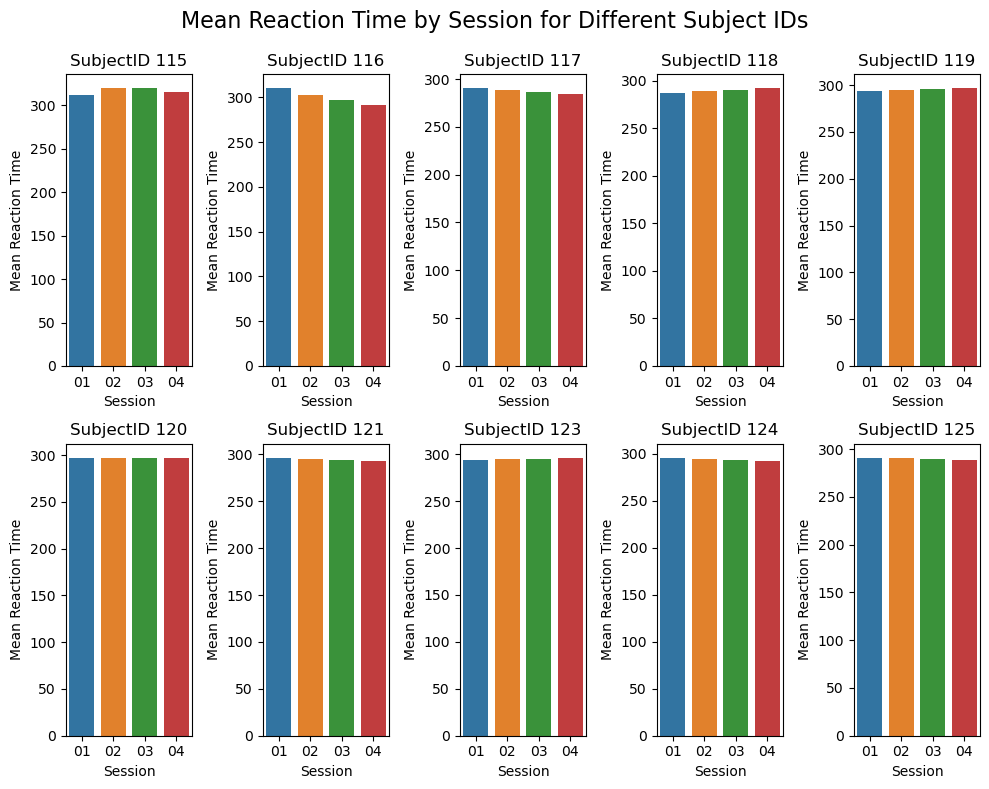

In [9]:
subjectIDs = results_df['SubjectID'].unique()

# Create a single figure with a grid of 5x2 subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 8))
fig.suptitle('Mean Reaction Time by Session for Different Subject IDs', fontsize=16)

for i, subjectID in enumerate(subjectIDs):
    row, col = divmod(i, 5)  # Calculate row and column indices for subplots
    ax = axes[row, col]
    
    session_means = results_df[results_df['SubjectID'] == subjectID].groupby('Session')['Mean'].mean()
    sns.barplot(x=session_means.index, y=session_means, ax=ax)
    
    ax.set_ylabel('Mean Reaction Time')
    ax.set_title(f'SubjectID {subjectID}')
    ax.set_xlabel('Session')

# Remove any empty subplots
if len(subjectIDs) < 10:
    for i in range(len(subjectIDs), 10):
        row, col = divmod(i, 5)
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


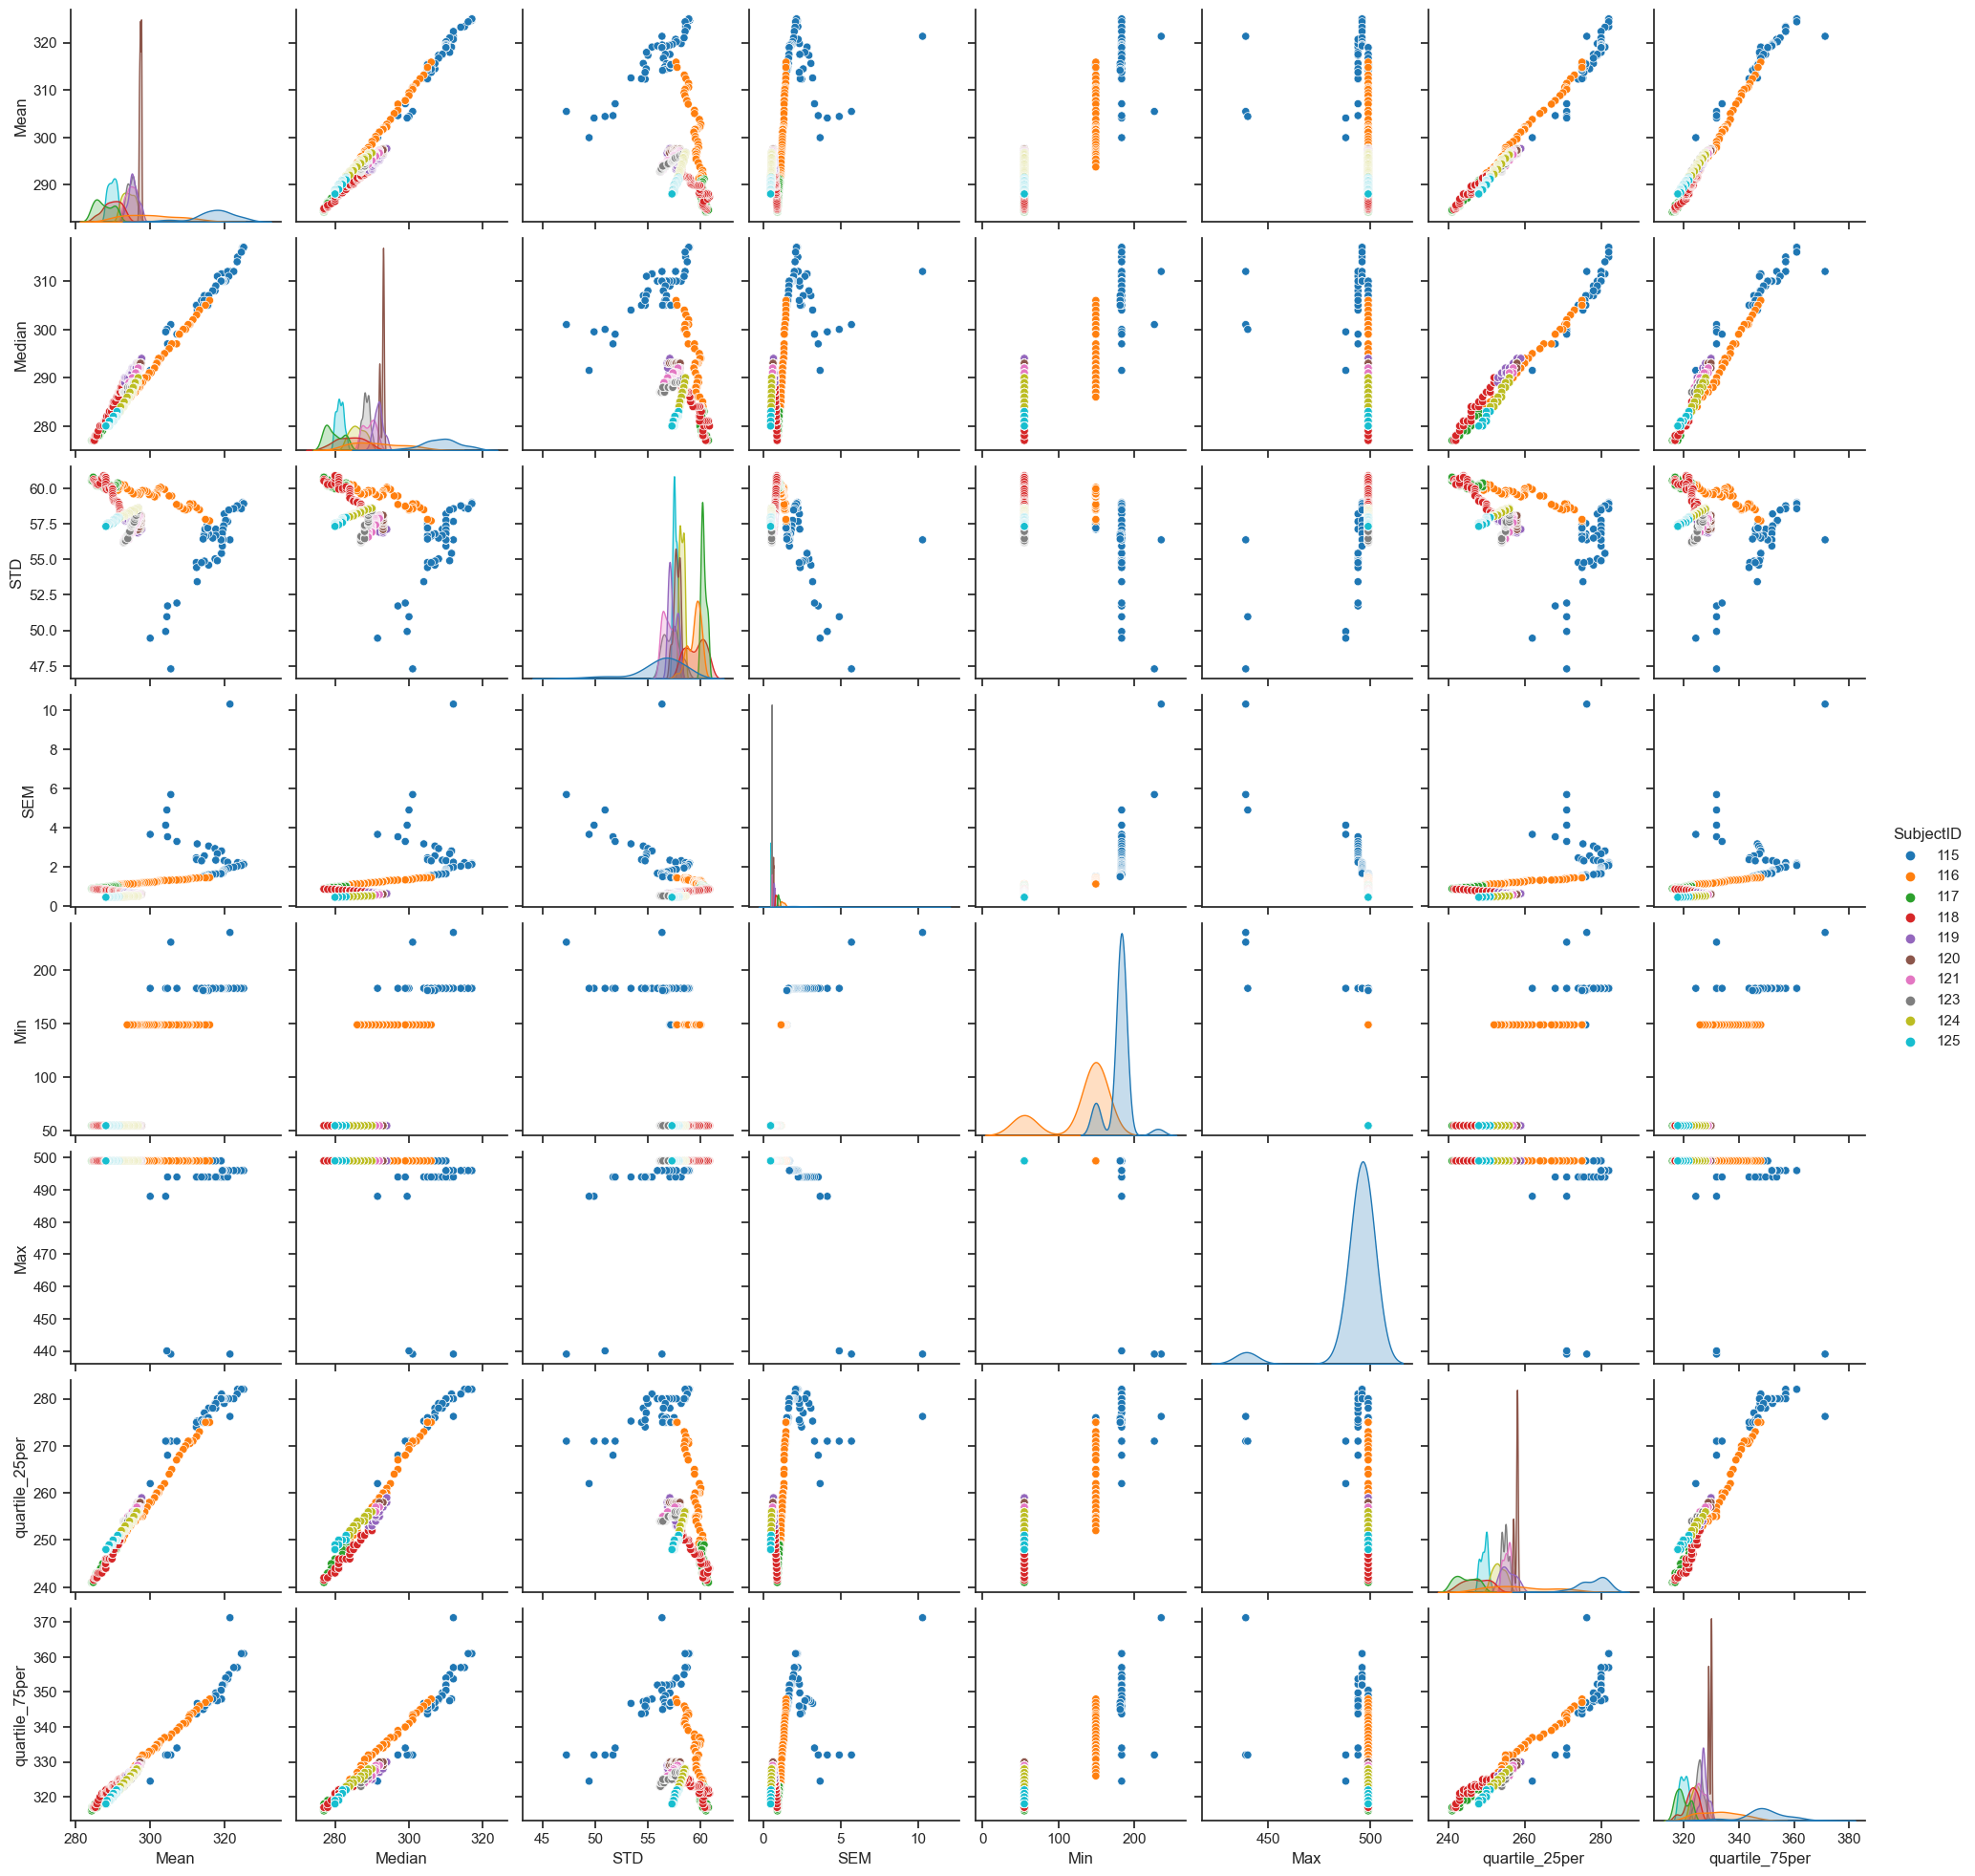

In [10]:

# Creating a pair plot with a distinct palette
sns.set(style="ticks")
sns.pairplot(results_df, hue="SubjectID", palette="tab10")

plt.show()



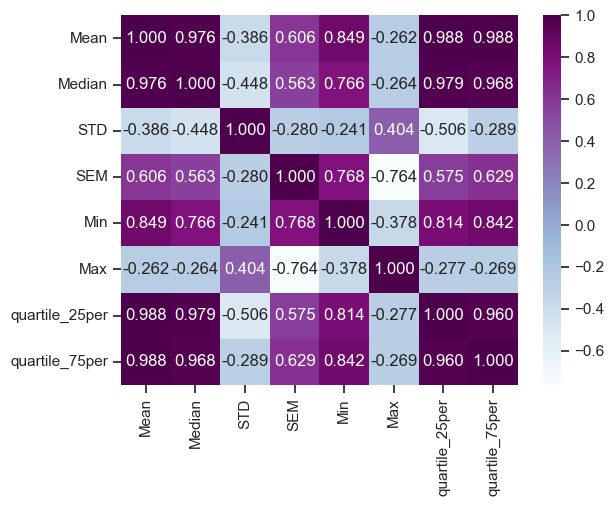

In [12]:
# Plot heatmap
heatmap = sns.heatmap(results_df.corr(numeric_only=True), cmap="BuPu", annot=True, fmt=".3f")